In [1]:
# Librería para manejar las contracciones que se presentan en el inglés.
!pip install contractions

In [2]:
# librería para manejar las flexiones gramaticales en el idioma inglés.
!pip install inflect
!pip install --disable-pip-version-check --progress-bar off -q https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

# YELP: Grupo 19

In [3]:
import string

import numpy as np
import pandas as pd
import warnings; warnings.simplefilter('ignore')
import nltk
import re, string, unicodedata
import contractions
##from pandas_profiling import ProfileReport
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score

In [4]:
pd.set_option('display.max_colwidth', None)

In [5]:
# Descargando las stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /home/andy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/andy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/andy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
def tokenizer(text):
    return word_tokenize(text)

## Entendimiento y preparación de los datos

### Lectura y reportes

Se toma una muestra aleatoria de los datos, puesto que realizar el entrenamiento con la cantidad original de los datos (aprox. 300 mil) implicaría un costo computacional muy alto. Nos aseguramos de tomar datos distribuidos equitativamente entre ambas clases, a fin de evitar desbalances.

In [7]:
reviews_df = pd.read_csv('reviews_train_val.csv', sep = ',')

from sklearn.utils import resample

neg_class_resampled = resample(
    reviews_df, replace=False, n_samples=50000,
    random_state=1234,
)
reviews_df = neg_class_resampled.reset_index(drop=True)

In [8]:
reviews_df.shape

(50000, 2)

In [9]:

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd


def mostrar_grafico(palabras,stopwords=[]):
    comment_words = ''

    # iterate through the csv file
    for val in palabras:

        # typecaste each val to string
        val = str(val)

        # split the value
        tokens = val.split()

        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)

    # plot the WordCloud image
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()

def mostrar_grafico2(palabras):
    comment_words = ''
    # iterate through the csv file
    for t in palabras:
        comment_words += " ".join(t)+" "

    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = [],
                    min_font_size = 10).generate(comment_words)

    # plot the WordCloud image
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()

In [10]:
reviews_df.sample(5)

,text,stars
27506,"Being from NM we are disappointed sometimes as some of the entres are portrayed as authentic but are not true NM, added flare or... the additives detract from the true awesomeness of authentic meztiso cuisine. Keep it real, keep it simple keep it NM! Sadie's, Los Quates, Maria's, The Pink Adobe and.... so many real examples. Please take the hype out of the menu and the ""pretty"" off the plate. Authentic boils down to the dish and it's flavor, nothing else is needed.",3
21082,"Great steak (Ribeye), great service (sat at the bar as I am on business and flying solo) great bourbon selection, only a few beers on tap but it worked... \nWould definitely come back if in the area!",5
7254,"This place was phenomenal. The music was amazing, the food was delicious, and the staff were very friendly. We came here for a bachelor party and had 11 people, but they made room for us and let us enjoy ourselves. 100% coming back here again.",5
16237,"I came to Sushi Rose to celebrate a friend's birthday (free AYCE on your birthday!) and I was pleasantly surprised. The food was really good. Many rolls come with cream cheese - which I LOVE! Overall, we found that the sushi rolls were good but the fried ones were definitely not exceptional. \n\nThe service was okay, nothing spectacular, but there was nothing to complain about. They have a friendly staff who manages to keep up with the busy environment. I'll definitely be going back, especially for the birthday perks.",4
12224,What a nice restaurant...owner is great and the food is wonderful...ingredients are fresh and flavorful...do not miss this place!,5


---------- Words count ----------


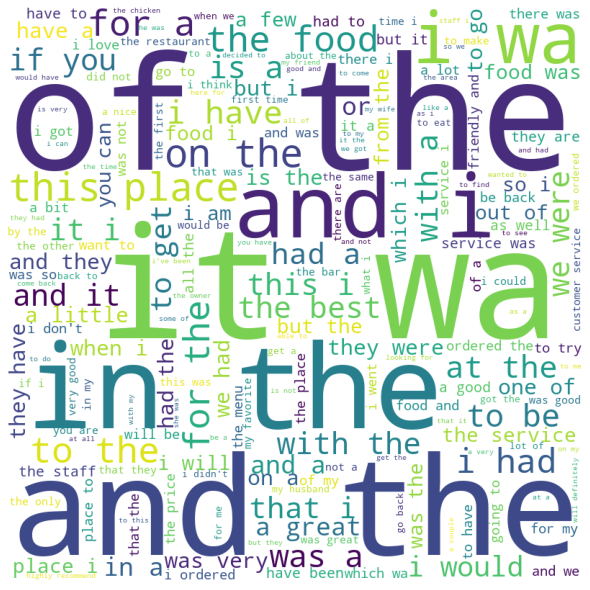

In [11]:
print(f'---------- Words count ----------')
mostrar_grafico(reviews_df["text"])

In [12]:
reviews_df['stars'].value_counts(dropna = False, normalize = True)

5    0.46358
4    0.20264
1    0.15516
3    0.09910
2    0.07952
Name: stars, dtype: float64

In [13]:
textos = reviews_df.copy()
textos['Conteo'] = [len(x) for x in textos['text']]
textos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['text']]
textos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['text']]

# Se realiza un perfilamiento de los datos con la librería pandas profiling
##ProfileReport(textos)

### Preparación

- Vamos a filtrar los textos que no tienen etiqueta y ver la cantidad de registros que se tienen por categoría

In [14]:
# Se filtran los que no tienen etiqueta
reviews_labeled_df = reviews_df.loc[reviews_df['stars'].notnull()]
reviews_labeled_df.shape

(50000, 2)

In [15]:
# Cantidad de registros por cada categoria
reviews_labeled_df['stars'].value_counts(dropna = False, normalize = True)

5    0.46358
4    0.20264
1    0.15516
3    0.09910
2    0.07952
Name: stars, dtype: float64

- Seguimos haciendo una division de los datos para entrenamiento y test

In [16]:

reviews_labeled_df = neg_class_resampled

X_train, X_test, y_train, y_test = train_test_split(reviews_labeled_df['text'], reviews_labeled_df['stars'], test_size = 0.2, stratify = reviews_labeled_df['stars'], random_state = 1)



X_train.shape

(40000,)

In [17]:
pd.Series(y_train).value_counts(normalize = True)

5    0.463575
4    0.202650
1    0.155150
3    0.099100
2    0.079525
Name: stars, dtype: float64

In [18]:
X_test.shape

(10000,)

In [19]:
pd.Series(y_test).value_counts(normalize = True)

5    0.4636
4    0.2026
1    0.1552
3    0.0991
2    0.0795
Name: stars, dtype: float64

- #### Corrección de las contracciones

In [20]:
X_train

247596                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [21]:
X_train = X_train.apply(contractions.fix)
X_test = X_test.apply(contractions.fix)
X_train.head()

247596                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

- #### Tokenizacion

In [22]:
X_train = X_train.apply(word_tokenize)
X_test = X_test.apply(word_tokenize)
X_train.head()

247596                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      [This, is, probably, the, best, amazing, hiking, place, to, go, to, it, is, so, amazing, so, awesome, I, think, if, there, a, award, they, would, win]
160846                                                                       [Walked, in, for, lunch, ., I, was, the, only, one, there, ., No, employee, in, sight, ., After, standing, at, the, counter, for, five, minutes, an, employee, appeared, ., She, walked, up, to, the, counter, and, just, stood, there, ., Did, not, greet, me, ., Had, a, pen, in, hand

- #### Limpieza

In [23]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    cachedStopWords = stopwords.words("english")

    for word in words:
        if word not in cachedStopWords:
            if word == 'one' or word == 'also': continue
            new_words.append(word)
    return new_words

def preprocessing(words):
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

In [24]:
X_train = X_train.apply(preprocessing)
X_test = X_test.apply(preprocessing)
X_train.head()

247596                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         [probably, best, amazing, hiking, place, go, amazing, awesome, think, award, would, win]
160846                                                                                                                          

---------- Words count----------


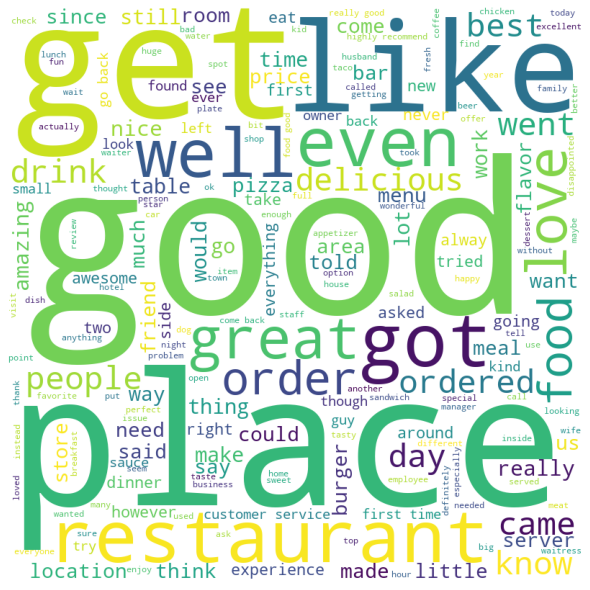

In [25]:
print(f'---------- Words count----------')

mostrar_grafico2(X_train)


- #### Normalizacion

In [26]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

In [27]:
X_train = X_train.apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
X_test = X_test.apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
X_train.head()

247596                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          [prob, best, amaz, hik, plac, go, amaz, awesom, think, award, would, win, probably, best, amaze, hike, place, go, amaze, awesome, think, award, would, win]
160846             [walk, lunch, employ, sight, stand, count, fiv, minut, employ, appear, walk, count, stood, greet, pen, hand, assum, ready, tak, ord, ord, sit, boo, wait, food, watch, employ, grab, phon, walk, bathroom, quit, tim, watch, shuffl, back, ov, grab, pizz, shuffl, tabl, drop, pizz, good, undercook, war

In [28]:
X_train = X_train.apply(lambda x: ' '.join(map(str, x)))
X_test = X_test.apply(lambda x: ' '.join(map(str, x)))
X_train.head()

247596                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

- #### BagOfWords

Se escogen únicamente aquellos tokens que no superen el 50% de la frecuencia en los datos

In [29]:


bow =  CountVectorizer(max_df = 0.5, min_df = 0.001)

bow.fit(X_train)

X_train = bow.transform(X_train).toarray()
X_test = bow.transform(X_test).toarray()

In [30]:
len(bow.vocabulary_)

5334

## LogisticRegression (Andres Bayona)

In [31]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

predictors = [
    ("pca", PCA(90)),
    ("clf", LogisticRegression()),
]
predictor_pipeline = Pipeline(predictors)


param_gridPCA2 = {
    "clf__penalty": ["l2", "l1" ],
    "clf__C": [10, 50, 100, 150],
    "clf__solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    "pca__n_components": [25, 50, 100],
    "clf__multi_class" :['auto'],
    "clf__max_iter": [3000],
}


grid_search = GridSearchCV(
   predictor_pipeline,
    param_gridPCA2,
    error_score=0.0,
    verbose=1,
    scoring=["recall_micro", "recall_macro", "recall_weighted"],
    cv=3,
    refit="recall_weighted",
    n_jobs = 50

)

In [32]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


GridSearchCV(cv=3, error_score=0.0,
             estimator=Pipeline(steps=[('pca', PCA(n_components=90)),
                                       ('clf', LogisticRegression())]),
             n_jobs=50,
             param_grid={'clf__C': [10, 50, 100, 150], 'clf__max_iter': [3000],
                         'clf__multi_class': ['auto'],
                         'clf__penalty': ['l2', 'l1'],
                         'clf__solver': ['newton-cg', 'lbfgs', 'liblinear',
                                         'sag', 'saga'],
                         'pca__n_components': [25, 50, 100]},
             refit='recall_weighted',
             scoring=['recall_micro', 'recall_macro', 'recall_weighted'],
             verbose=1)

In [33]:
grid_search.best_params_

{'clf__C': 50,
 'clf__max_iter': 3000,
 'clf__multi_class': 'auto',
 'clf__penalty': 'l2',
 'clf__solver': 'newton-cg',
 'pca__n_components': 100}

In [34]:
grid_search.best_score_

0.6106499820137622

In [35]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__max_iter,param_clf__multi_class,param_clf__penalty,param_clf__solver,param_pca__n_components,...,split2_test_recall_macro,mean_test_recall_macro,std_test_recall_macro,rank_test_recall_macro,split0_test_recall_weighted,split1_test_recall_weighted,split2_test_recall_weighted,mean_test_recall_weighted,std_test_recall_weighted,rank_test_recall_weighted
0,60.703123,11.103125,2.138637,0.668417,10,3000,auto,l2,newton-cg,25,...,0.373197,0.372071,0.004617,65,0.570721,0.561614,0.569039,0.567125,0.003957,69
1,48.346124,12.993127,2.655573,0.574739,10,3000,auto,l2,newton-cg,50,...,0.407296,0.405105,0.003685,43,0.592920,0.582690,0.591090,0.588900,0.004455,41
2,85.300323,19.772070,3.098262,0.828740,10,3000,auto,l2,newton-cg,100,...,0.444255,0.437198,0.004991,15,0.608070,0.604590,0.615240,0.609300,0.004434,8
3,49.414182,19.324619,1.727382,0.579626,10,3000,auto,l2,lbfgs,25,...,0.374190,0.372165,0.003402,64,0.569447,0.562814,0.569189,0.567150,0.003068,67
4,35.049239,1.394721,2.076147,0.179431,10,3000,auto,l2,lbfgs,50,...,0.409515,0.406026,0.003704,36,0.593595,0.583590,0.592215,0.589800,0.004427,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,31.742336,4.917104,0.000000,0.000000,150,3000,auto,l1,sag,50,...,0.000000,0.000000,0.000000,85,0.000000,0.000000,0.000000,0.000000,0.000000,85
116,31.832457,1.342902,0.000000,0.000000,150,3000,auto,l1,sag,100,...,0.000000,0.000000,0.000000,85,0.000000,0.000000,0.000000,0.000000,0.000000,85
117,33.773815,4.683134,0.665333,0.038969,150,3000,auto,l1,saga,25,...,0.373726,0.371906,0.005259,67,0.571621,0.561164,0.568664,0.567150,0.004401,68
118,24.664980,3.973237,0.870210,0.037521,150,3000,auto,l1,saga,50,...,0.404453,0.405871,0.004096,37,0.596970,0.585240,0.588165,0.590125,0.004986,31


In [36]:
best_model = grid_search.best_estimator_

In [37]:
preds_train = best_model.predict(X_train)
preds_test = best_model.predict(X_test)

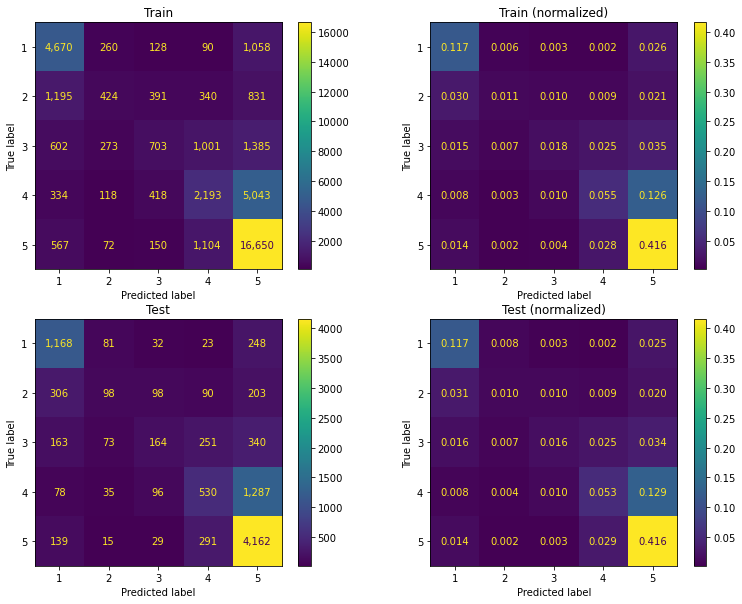

In [38]:

from sklearn.metrics import confusion_matrix

cm_train = confusion_matrix(y_train, preds_train, labels = best_model.classes_)
cm_train_norm = confusion_matrix(y_train, preds_train, labels = best_model.classes_, normalize = 'all')
cm_test = confusion_matrix(y_test, preds_test, labels = best_model.classes_)
cm_test_norm = confusion_matrix(y_test, preds_test, labels = best_model.classes_, normalize = 'all')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (13, 10))
ConfusionMatrixDisplay(confusion_matrix = cm_train, display_labels = best_model.classes_).plot(ax = ax1, values_format = ',.0f')
ConfusionMatrixDisplay(confusion_matrix = cm_train_norm, display_labels = best_model.classes_).plot(ax = ax2, values_format = '.3f')
ConfusionMatrixDisplay(confusion_matrix = cm_test, display_labels = best_model.classes_).plot(ax = ax3, values_format = ',.0f')
ConfusionMatrixDisplay(confusion_matrix = cm_test_norm, display_labels = best_model.classes_).plot(ax = ax4, values_format = '.3f')

ax1.set_title('Train')
ax2.set_title('Train (normalized)')
ax3.set_title('Test')
ax4.set_title('Test (normalized)')
plt.show()

In [39]:
from sklearn.metrics import classification_report

print(classification_report(y_test, preds_test))

              precision    recall  f1-score   support

           1       0.63      0.75      0.69      1552
           2       0.32      0.12      0.18       795
           3       0.39      0.17      0.23       991
           4       0.45      0.26      0.33      2026
           5       0.67      0.90      0.77      4636

    accuracy                           0.61     10000
   macro avg       0.49      0.44      0.44     10000
weighted avg       0.56      0.61      0.57     10000

